# FINAL PROJECT - DOG BREED DETECTION
###  Name : Sharjil Khan

# IMPORTS

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib

import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image

from sklearn.metrics import auc
from sklearn.metrics import roc_curve


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))
    
print(sys.version)
print(device_lib.list_local_devices())

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

Using TensorFlow backend.


Tensorflow is installed and is version:  1.11.0
Keras is installed and is version:  2.1.6-tf
[[22. 28.]
 [49. 64.]]
3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10424641151053139053
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17352610315248148125
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Some General Functions used in various places

In [2]:
# TO CREATE THE LOGS FOR TENSOR BOARD
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
        
# PLOT ACCURACY AND LOSS CHARTS FOR THE MODELS AS THEY TRAIN
def plot_accuracies_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'g-', label='Training acc', color = 'brown')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
 
    plt.plot(epochs, loss, 'g-', label='Training loss', color = 'brown')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    

# TO SHOW CONFUSION MATRIX
def show_confusion_matrix(cm, target_names):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# SHOW RESULTS OF CLASSIFICATION
def show_results(model, test_generator):
    # GET ACCURACY SCORE ON THE TEST SET
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
    print('\nTEST accuracy:', test_acc)
    print('TEST loss:', test_loss)
    predictions = []
    labels = []
    indexes = []

    i = 0
        
    for data_batch, labels_batch in test_generator:
        labels.extend(labels_batch)
        predictions.extend(model.predict_classes(data_batch))
        i = i + 1
        if i==len(test_generator):
            break
        
    for i in range (len(test_generator)):
        indexes.extend(next(test_generator.index_generator))
        
    labels = [np.where(r==1)[0][0] for r in labels]
    #print("Lables:")
    #print(labels)
    #print("Predictions:")
    #print(predictions)
    print('\nConfusion Matrix')
    cm = confusion_matrix(labels, predictions)
    print(cm)
    print('\nClassification Report')
    target_names = [*test_generator.class_indices.keys()]
    print(classification_report(labels, predictions, target_names=target_names))
    show_confusion_matrix(cm, target_names)
    

# FUNCTION TO CHANGE THE DIRECTORY NAMES 
def change_directory_names (path, change = False):
    files = os.listdir(path)
    for f in files:
        # check if the file name has numbers
        has_number = re.search(r'\d+', f)
        if has_number != None:
            src = os.path.join(path,f)
            print("\nSrc:%s"%src)
            
            f_prime = "-".join(f.split("-")[1:])
            if f_prime != "":
                dst = os.path.join(path,f_prime)
            else:
                dst = os.path.join(path,f)
            print("dst : %s\n"%dst)
            if change == True:
                print("Changing directory Name")
                shutil.move(src,dst)
        else :
            print("no numbers --> %s"%f)
    return




In [3]:
# CHANGING NAMES OF THE DIRECTORIES AND GETTING THE VALUES FOR THE DICT ENTRY
change_directory_names("./dog_images_all", change = True)


no numbers --> Doberman
no numbers --> schipperke
no numbers --> Border_terrier
no numbers --> Airedale
no numbers --> Old_English_sheepdog
no numbers --> Australian_terrier
no numbers --> Ibizan_hound
no numbers --> Scottish_deerhound
no numbers --> beagle
no numbers --> miniature_poodle
no numbers --> briard
no numbers --> Shih-Tzu
no numbers --> Irish_setter
no numbers --> toy_terrier
no numbers --> borzoi
no numbers --> Lhasa
no numbers --> American_Staffordshire_terrier
no numbers --> Border_collie
no numbers --> Pomeranian
no numbers --> papillon
no numbers --> standard_schnauzer
no numbers --> Pembroke
no numbers --> Cardigan
no numbers --> Staffordshire_bullterrier
no numbers --> Sussex_spaniel
no numbers --> basset
no numbers --> toy_poodle
no numbers --> Kerry_blue_terrier
no numbers --> Great_Pyrenees
no numbers --> EntleBucher
no numbers --> whippet
no numbers --> Lakeland_terrier
no numbers --> cairn
no numbers --> African_hunting_dog
no numbers --> Norwegian_elkhound
no n

# Create Dog Directories and split train, validation & test

In [4]:



# CREATES THE DIRECTORY STRUCTURES WITH THE PROPER TRAINING, VALIDATION AND TEST SPLIT
def create_dog_images_dirs (base_images, dir_split_list):
    
    # Check if a list of dogs where provided if not return
    if (len(dir_split_list)) == 0:
        return 
    
    # Create the basic directory paths for the three main dirs
    testval_dirs = os.path.join(os.path.dirname(base_images) ,'testval_dogs')
    train_d = os.path.join(testval_dirs,'train')
    val_d = os.path.join(testval_dirs,'validation')
    test_d = os.path.join(testval_dirs,'test')
                        
    # Remove the old directories.    
    if os.path.exists(testval_dirs):
             shutil.rmtree(testval_dirs)
            
    # Create new directories.            
    os.makedirs(testval_dirs)
    os.makedirs(train_d)
    os.makedirs(val_d)
    os.makedirs(test_d) 
    
    # Iterate through each dog  
    for dog in dir_split_list:

        # Get the dogs name
        name = dog['name']
    
        # Create dirs with the name of the dog
        dog_train_dst = os.path.join(train_d, name)
        dog_val_dst = os.path.join(val_d, name)
        dog_test_dst = os.path.join(test_d, name)
    
        os.makedirs(dog_train_dst)
        os.makedirs(dog_val_dst)
        os.makedirs(dog_test_dst)
    
        # Collect info about this dogs directory and calculate the split numbers
        path, dirs, files = os.walk(os.path.join(base_images, name)).__next__()
        file_count = len(files)    
        train_count = int(file_count * dog['train'])
        val_count = int(file_count * dog['val'])
        test_count = file_count - train_count - val_count

        # Copy the files
        for i, file in enumerate(files, start =1):
            if i <= train_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_train_dst, file))
            if i <= val_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_val_dst, file))
            if i <= test_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_test_dst, file))  
    return train_d, val_d, test_d
 


# Returns a dict of dogs. the number of dogs depends on count
def return_dict(path, trn, vl, tst, count):
    lst_dict = []
    files = os.listdir(path)
    for i, f in enumerate(files) :
        lst_dict.append({'name': f, 'train': trn, 'val': vl, 'test': tst})
        if i == (count-1):
            break
    return lst_dict


def dog_dict_list(path, trn, vl, tst, number_of_dogs):

    dogs_count = return_dict(path, trn, vl, tst, number_of_dogs)

    # ELSE NUM OF DOGS IS USED TO CHOOSE BETWEEN 2, 4, 8 
    dogs2 = [{'name': 'golden_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'curly-coated_retriever', 'train': trn, 'val': vl, 'test': tst}
            ]

    dogs4 = [{'name': 'golden_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'curly-coated_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Japanese_spaniel', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Chihuahua', 'train': trn, 'val': vl, 'test': tst}
            ]

    dogs8 = [{'name': 'golden_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'curly-coated_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Australian_terrier', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Chihuahua', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'German_shepherd', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Japanese_spaniel', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Tibetan_mastiff', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'toy_poodle', 'train': trn, 'val': vl, 'test': tst}
            ]


    if number_of_dogs == (2 | 4 | 8 ):
        if number_of_dogs == 2: 
             dogs  = dogs2
        elif number_of_dogs == 4: 
             dogs  = dogs4
        elif number_of_dogs== 8: 
             dogs  = dogs8
    else:
        dogs  = dogs_count
    return dogs


def create_data_generatores(train_dir, validation_dir, test_dir):
    # All images will be rescaled by 1./255
    datagen = ImageDataGenerator(rescale=1./255)

    # generator for the training data
    train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(64, 64),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

    # generator for the validation data
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(64, 64),
        batch_size=8,
        class_mode='categorical')

    # generator for the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        # NO shuffle for the test set to be able to track the file names
        shuffle = False,
        batch_size=8,  # this just makes sure it gets through memory
        class_mode='categorical')
    return train_generator, validation_generator, test_generator


    
 

# FINAL CNN MODEL USED 

In [5]:
K.clear_session()

def CNN_model_create(train_generator, num_of_dogs):
    for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    #data_batch, labels_batch = train_generator[0]
    batch_size = len(labels_batch)
    print("Batch Size: %d"%batch_size)

    model = Sequential(name='FiveLayerModel')
    model.add(Conv2D(batch_size, (3, 3), padding='same', activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv3'))
    model.add(MaxPooling2D((2, 2), name='max_pool3'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv4'))
    model.add(MaxPooling2D((2, 2), name='max_pool4'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name = 'conv5'))
    model.add(Conv2D(512,(3, 3), padding='same', activation='relu', name = 'conv6'))
    model.add(MaxPooling2D((2, 2), name='max_pool5'))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(NUM_OF_DOGS, kernel_initializer='glorot_uniform', activation='softmax', name='fc2'))

    model.compile(loss='categorical_crossentropy',
                  optimizer = 'rmsprop',
                  #optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model



# Fit model
def fit_model(model, train_generator, validation_generator, epoc):
    history_CNN_model = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=epoc,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)])
    return history_CNN_model
    


# SPECIFY NUMBER OF DOGS AND RUN THROUGH THE WHOLE PROCESS

In [6]:
PATH = './dog_images_all'
TRN = 0.70  # Training data percentage
VL = 0.15   # Validation data percentage
TST = 0.15  # Test data percentage.

def run_entire_pipeline(num_of_dogs, epoc):
    # CREATE THE DIRECTORIES
    train_dir, validation_dir, test_dir = create_dog_images_dirs (PATH, dog_dict_list(PATH, TRN, VL, TST, num_of_dogs))

    # THEN CREATE THE DATA GENERATORS
    train_generator, validation_generator, test_generator = create_data_generatores(train_dir, validation_dir, test_dir)

    # CREATE THE MODEL
    CNN_model = CNN_model_create(train_generator, NUM_OF_DOGS)

    # GET A SUMMARY FOR THE MODEL
    CNN_model .summary()

    # FIT MODEL
    history = fit_model(CNN_model, train_generator, validation_generator, epoc)

    # PLOT ACCURACIES DURING TRAINING
    plot_accuracies_loss(history)

    # SHOW RESULTS ON TEST SET
    show_results(CNN_model, test_generator)
    return

# RUN THE WHOLE PIPELINE WITH 16 DOGS

Found 1983 images belonging to 16 classes.
Found 419 images belonging to 16 classes.
Found 441 images belonging to 16 classes.
data batch shape: (8, 64, 64, 3)
labels batch shape: (8, 16)
Batch Size: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 64, 64, 8)         224       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 32, 32, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        4672      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 16, 16, 64)        0         
_________________________________________________________________
dropou

100/100 [==============================] - 4s 37ms/step - loss: 1.1423 - acc: 0.6250 - val_loss: 0.9440 - val_acc: 0.6937
Epoch 42/50
100/100 [==============================] - 4s 37ms/step - loss: 1.2471 - acc: 0.5887 - val_loss: 0.8785 - val_acc: 0.7089
Epoch 43/50
100/100 [==============================] - 3s 34ms/step - loss: 1.0109 - acc: 0.6596 - val_loss: 0.7873 - val_acc: 0.7595
Epoch 44/50
100/100 [==============================] - 4s 36ms/step - loss: 1.0452 - acc: 0.6575 - val_loss: 0.7435 - val_acc: 0.7797
Epoch 45/50
100/100 [==============================] - 4s 36ms/step - loss: 0.9307 - acc: 0.6970 - val_loss: 0.7811 - val_acc: 0.7519
Epoch 46/50
100/100 [==============================] - 4s 37ms/step - loss: 0.8682 - acc: 0.7350 - val_loss: 0.7429 - val_acc: 0.7468
Epoch 47/50
100/100 [==============================] - 4s 36ms/step - loss: 0.9351 - acc: 0.6825 - val_loss: 0.6614 - val_acc: 0.7823
Epoch 48/50
100/100 [==============================] - 4s 35ms/step - loss

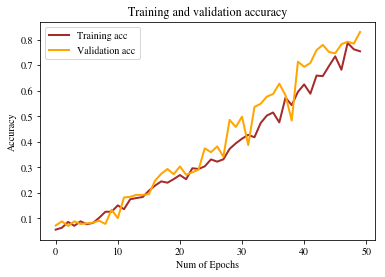

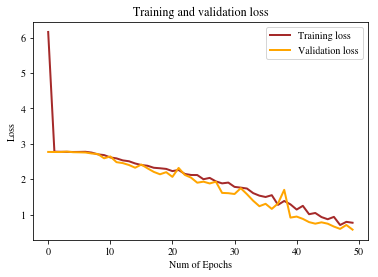


TEST accuracy: 0.8360655737704918
TEST loss: 0.5660964376263762

Confusion Matrix
[[26  0  1  0  0  0  0  0  1  0  0  0  2  1  0  0]
 [ 0 26  2  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 1  0 19  0  0  1  0  0  4  0  0  0  1  1  0  0]
 [ 0  0  0 22  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  1  0 27  1  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0 21  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  1 14  2  1  3  0  0  2  5  1  0]
 [ 0  0  0  0  0  0  0 20  1  0  0  2  0  2  1  0]
 [ 0  0  0  0  0  0  0  0 36  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  2  2 25  0  0  0  2  0  0]
 [ 0  0  0  0  1  0  0  0  1  0 25  1  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1  0  1 22  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0  0  0 21  1  0  0]
 [ 0  0  0  0  0  1  0  0  1  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1 23  0]
 [ 0  0  0  0  4  1  0  0  0  1  0  0  0  0  0 21]]

Classification Report
                      precision    recall  f1-score   support

            Ai

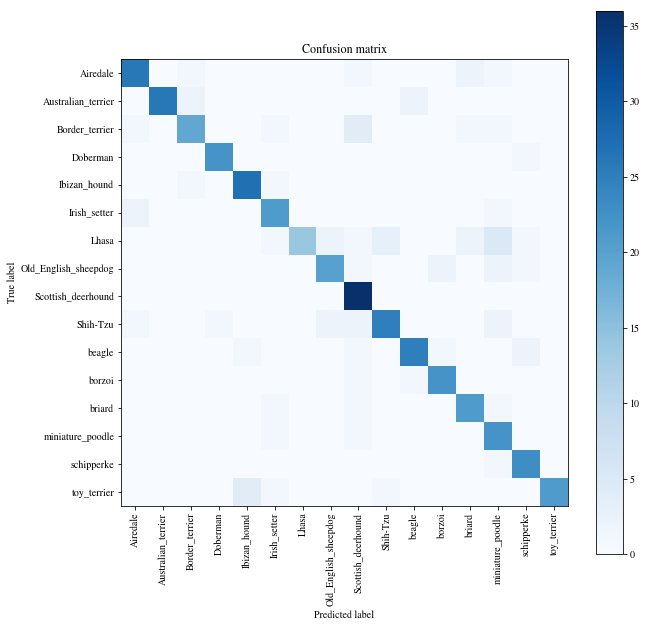

In [7]:
NUM_OF_DOGS = 16
EPOC = 50
run_entire_pipeline(NUM_OF_DOGS, EPOC)